In [15]:
import os
os.getcwd()

'/content'

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
os.getcwd()

'/content'

In [0]:
dir = os.path.join('drive','My Drive','Colab Notebooks','faceNet')

In [19]:
dir

'drive/My Drive/Colab Notebooks/faceNet'

In [0]:
import operator
import numpy as np
from sklearn.model_selection import KFold
from scipy import interpolate


def evaluate(distances, labels, nrof_folds=10):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 30, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, distances,
        labels, nrof_folds=nrof_folds)
    thresholds = np.arange(0, 30, 0.001)
    val, val_std, far = calculate_val(thresholds, distances,
        labels, 1e-3, nrof_folds=nrof_folds)
    return tpr, fpr, accuracy, val, val_std, far


def calculate_roc(thresholds, distances, labels, nrof_folds=10):

    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, distances[train_set], labels[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, distances[test_set], labels[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], distances[test_set], labels[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc


def calculate_val(thresholds, distances, labels, far_target=1e-3, nrof_folds=10):
    nrof_pairs = min(len(labels), len(distances))
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, distances[train_set], labels[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, distances[test_set], labels[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    if n_diff == 0:
        n_diff = 1
    if n_same == 0:
        return 0,0
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far


def plot_roc(fpr,tpr,figure_name="roc.png"):
    import matplotlib.pyplot as plt
    plt.switch_backend('Agg')

    from sklearn.metrics import roc_curve, auc
    roc_auc = auc(fpr, tpr)
    fig = plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='red',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    fig.savefig(figure_name, dpi=fig.dpi)


In [0]:
import torch
from torch.autograd import Function
from torch.nn.modules.distance import PairwiseDistance


class TripletLoss(Function):
    
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.pdist  = PairwiseDistance(2)
        
    def forward(self, anchor, positive, negative):
        pos_dist   = self.pdist.forward(anchor, positive)
        neg_dist   = self.pdist.forward(anchor, negative)
        
        hinge_dist = torch.clamp(self.margin + pos_dist - neg_dist, min = 0.0)
        loss       = torch.mean(hinge_dist)
        return loss


In [0]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet50

res50 = resnet50(pretrained = True)
for parameter in res50.parameters():
    parameter.requires_grad = False


class FaceNetModel(nn.Module):
    def __init__(self, embedding_size, num_classes, pretrained=True):
        super (FaceNetModel, self).__init__()
        
        self.model            = res50
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(2048*8*8, self.embedding_size)
        self.model.classifier = nn.Linear(self.embedding_size, num_classes)
    
    
    def l2_norm(self, input):
        input_size = input.size()
        buffer     = torch.pow(input, 2)
        normp      = torch.sum(buffer, 1).add_(1e-10)
        norm       = torch.sqrt(normp)
        _output    = torch.div(input, norm.view(-1, 1).expand_as(input))
        output     = _output.view(input_size)
    
        return output
    
    
    def forward(self, x):
      
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
       
        #print(x.size())
        x = x.view(x.size(0), -1)
        x = self.model.fc(x)
        
        self.features = self.l2_norm(x)
        # Multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha         = 10
        self.features = self.features*alpha
        
        return self.features
    
    
    def forward_classifier(self, x):
        features = self.forward(x)
        res      = self.model.classifier(features)
        
        return res


In [0]:
import os
import numpy as np
import pandas as pd
from skimage import io
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image


class TripletFaceDataset(Dataset):

    def __init__(self, root_dir, csv_name, num_triplets, transform = None):
        
        self.root_dir          = root_dir
        self.df                = pd.read_csv(csv_name)
        self.num_triplets      = num_triplets
        self.transform         = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_triplets)
    
    
    @staticmethod
    def generate_triplets(df, num_triplets):
        
        def make_dictionary_for_face_class(df):

            '''
              - face_classes = {'class0': [class0_id0, ...], 'class1': [class1_id0, ...], ...}
            '''
            face_classes = dict()
            for idx, label in enumerate(df['class']):
                if label not in face_classes:
                    face_classes[label] = []
                face_classes[label].append(df.iloc[idx, 0])
            return face_classes
        
        triplets    = []
        classes     = df['class'].unique()
        face_classes = make_dictionary_for_face_class(df)
         
        for _ in range(num_triplets):

            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - anchor and positive images in pos_class
              - negative image in neg_class
              - at least, two images needed for anchor and positive images in pos_class
              - negative image should have different class as anchor and positive images by definition
            '''
        
            pos_class = np.random.choice(classes)
            neg_class = np.random.choice(classes)
            while len(face_classes[pos_class]) < 2:
                pos_class = np.random.choice(classes)
            while pos_class == neg_class:
                neg_class = np.random.choice(classes)
            
            pos_name = df.loc[df['class'] == pos_class, 'name'].values[0]
            neg_name = df.loc[df['class'] == neg_class, 'name'].values[0]

            if len(face_classes[pos_class]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                ianc = np.random.randint(0, len(face_classes[pos_class]))
                ipos = np.random.randint(0, len(face_classes[pos_class]))
                while ianc == ipos:
                    ipos = np.random.randint(0, len(face_classes[pos_class]))
            ineg = np.random.randint(0, len(face_classes[neg_class]))
            
            triplets.append([face_classes[pos_class][ianc], face_classes[pos_class][ipos], face_classes[neg_class][ineg], 
                             pos_class, neg_class, pos_name, neg_name])
        
        return triplets
    
    
    def __getitem__(self, idx):
        
        anc_id, pos_id, neg_id, pos_class, neg_class, pos_name, neg_name = self.training_triplets[idx]
        
        anc_img   = os.path.join(self.root_dir, str(pos_name), str(anc_id) + '.jpg')
        pos_img   = os.path.join(self.root_dir, str(pos_name), str(pos_id) + '.jpg')
        neg_img   = os.path.join(self.root_dir, str(neg_name), str(neg_id) + '.jpg')
        
        #anc_img   = io.imread(anc_img)
        #pos_img   = io.imread(pos_img)
        #neg_img   = io.imread(neg_img)
        
        anc_img = Image.open(anc_img)
        pos_img = Image.open(pos_img)
        neg_img = Image.open(neg_img)

        pos_class = torch.from_numpy(np.array([pos_class]).astype('long'))
        neg_class = torch.from_numpy(np.array([neg_class]).astype('long'))
        
        sample = {'anc_img': anc_img, 'pos_img': pos_img, 'neg_img': neg_img, 'pos_class': pos_class, 'neg_class': neg_class}

        if self.transform:
            sample['anc_img'] = self.transform(sample['anc_img'])
            sample['pos_img'] = self.transform(sample['pos_img'])
            sample['neg_img'] = self.transform(sample['neg_img'])
            
        return sample
    
    
    def __len__(self):
        
        return len(self.training_triplets)
    

def get_dataloader(train_root_dir,     valid_root_dir, 
                   train_csv_name,     valid_csv_name, 
                   num_train_triplets, num_valid_triplets, 
                   batch_size,         num_workers):
    
    data_transforms = {
        'train': transforms.Compose([
            #transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])]),
        'valid': transforms.Compose([
            #transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])}

    face_dataset = {
        'train' : TripletFaceDataset(root_dir     = train_root_dir,
                                     csv_name     = train_csv_name,
                                     num_triplets = num_train_triplets,
                                     transform    = data_transforms['train']),
        'valid' : TripletFaceDataset(root_dir     = valid_root_dir,
                                     csv_name     = valid_csv_name,
                                     num_triplets = num_valid_triplets,
                                     transform    = data_transforms['valid'])}

    dataloaders = {
        x: torch.utils.data.DataLoader(face_dataset[x], batch_size = batch_size, shuffle = False, num_workers = num_workers)
        for x in ['train', 'valid']}
    
    data_size = {x: len(face_dataset[x]) for x in ['train', 'valid']}

    return dataloaders, data_size

In [24]:
dir

'drive/My Drive/Colab Notebooks/faceNet'

In [0]:
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn.modules.distance import PairwiseDistance
import torchvision
from torchvision import transforms
#from eval_metrics import evaluate, plot_roc
#from utils import TripletLoss
#from models import FaceNetModel
#from data_loader import TripletFaceDataset, get_dataloader


In [26]:
'''
parser = argparse.ArgumentParser(description = 'Face Recognition using Triplet Loss')

parser.add_argument('--start-epoch', default = 0, type = int, metavar = 'SE',
                    help = 'start epoch (default: 0)')
parser.add_argument('--num-epochs', default = 20, type = int, metavar = 'NE',
                    help = 'number of epochs to train (default: 200)')
parser.add_argument('--num-classes', default = 10000, type = int, metavar = 'NC',
                    help = 'number of clases (default: 10000)')
parser.add_argument('--num-train-triplets', default = 10000, type = int, metavar = 'NTT',
                    help = 'number of triplets for training (default: 10000)')
parser.add_argument('--num-valid-triplets', default = 10000, type = int, metavar = 'NVT',
                    help = 'number of triplets for vaidation (default: 10000)')
parser.add_argument('--embedding-size', default = 128, type = int, metavar = 'ES',
                    help = 'embedding size (default: 128)')
parser.add_argument('--batch-size', default = 64, type = int, metavar = 'BS',
                    help = 'batch size (default: 128)')
parser.add_argument('--num-workers', default = 8, type = int, metavar = 'NW',
                    help = 'number of workers (default: 8)')
parser.add_argument('--learning-rate', default = 0.001, type = float, metavar = 'LR',
                    help = 'learning rate (default: 0.001)')
parser.add_argument('--margin', default = 0.5, type = float, metavar = 'MG',
                    help = 'margin (default: 0.5)')
parser.add_argument('--train-root-dir', default = os.path.join('dir','test'), type = str,
                    help = 'path to train root dir')
parser.add_argument('--valid-root-dir', default = os.path.join('dir','lfw'), type = str,
                    help = 'path to valid root dir')
parser.add_argument('--train-csv-name', default = os.path.join('dir','FaceNet','datasets','test_vggface2.csv'), type = str,
                    help = 'list of training images')
parser.add_argument('--valid-csv-name', default = os.path.join('dir','FaceNet','datasets','lfw.csv'), type = str,
                    help = 'list of validtion images')
'''
#args    = parser.parse_args()
embedding_size = 128
num_classes = 5000
learning_rate = 0.1
num_epochs = 200
#train_root_dir =  os.path.join(dir,'test')
train_root_dir = os.path.join(dir,'lfw_train')
valid_root_dir = os.path.join(dir,'lfw_test')
#train_csv_name = os.path.join(dir,'FaceNet','datasets','test_vggface2.csv')
train_csv_name = os.path.join(dir,'FaceNet','datasets','lfw_train.csv')
valid_csv_name = os.path.join(dir,'FaceNet','datasets','lfw_test.csv')
num_train_triplets = 3000
num_valid_triplets = 3000
batch_size = 64
num_workers = 8
margin = 0.5
start_epoch = 0
num_epochs = 20






device  = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
l2_dist = PairwiseDistance(2)
epoch_triplet_train_loss = []
epoch_triplet_test_loss = []
minibatch_triplet_train_loss = []
minibatch_triplet_test_loss = []


def main():
    
    model     = FaceNetModel(embedding_size = embedding_size, num_classes = num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    scheduler = lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.1)
    
    #if start_epoch != 0:
    #    checkpoint = torch.load('./log/checkpoint_epoch{}.pth'.format(start_epoch-1))
    #    model.load_state_dict(checkpoint['state_dict'])
    
    for epoch in range(start_epoch, num_epochs + start_epoch):
        
        print(80 * '=')
        print('Epoch [{}/{}]'.format(epoch, num_epochs + start_epoch - 1))
    
        data_loaders, data_size = get_dataloader(train_root_dir,     valid_root_dir,
                                                 train_csv_name,     valid_csv_name,
                                                 num_train_triplets, num_valid_triplets,   
                                                 batch_size,         num_workers)

        train_valid(model, optimizer, scheduler, epoch, data_loaders, data_size)

    print(80 * '=')

    
def train_valid(model, optimizer, scheduler, epoch, dataloaders, data_size):
    
    for phase in ['train','valid']:

        labels, distances = [], []
        triplet_loss_sum  = 0.0

        if phase == 'train':
            scheduler.step()
            model.train()
        else:
            model.eval()
    
        for batch_idx, batch_sample in enumerate(dataloaders[phase]):
                
            anc_img = batch_sample['anc_img'].to(device)
            pos_img = batch_sample['pos_img'].to(device)
            neg_img = batch_sample['neg_img'].to(device)
        
            pos_cls = batch_sample['pos_class'].to(device)
            neg_cls = batch_sample['neg_class'].to(device)
                            
            with torch.set_grad_enabled(phase == 'train'):
            
                # anc_embed, pos_embed and neg_embed are encoding(embedding) of image
                anc_embed, pos_embed, neg_embed = model(anc_img), model(pos_img), model(neg_img)
            
                # choose the hard negatives only for "training"
                pos_dist = l2_dist.forward(anc_embed, pos_embed)
                neg_dist = l2_dist.forward(anc_embed, neg_embed)
            
                all = (neg_dist - pos_dist < margin).cpu().numpy().flatten()
                if phase == 'train':
                    hard_triplets = np.where(all == 1)
                    if len(hard_triplets[0]) == 0:
                        continue
                else:
                    hard_triplets = np.where(all >= 0)
                
                anc_hard_embed = anc_embed[hard_triplets].to(device)
                pos_hard_embed = pos_embed[hard_triplets].to(device)
                neg_hard_embed = neg_embed[hard_triplets].to(device)
            
                anc_hard_img   = anc_img[hard_triplets].to(device)
                pos_hard_img   = pos_img[hard_triplets].to(device)
                neg_hard_img   = neg_img[hard_triplets].to(device)
            
                pos_hard_cls   = pos_cls[hard_triplets].to(device)
                neg_hard_cls   = neg_cls[hard_triplets].to(device)
            
                anc_img_pred   = model.forward_classifier(anc_hard_img).to(device)
                pos_img_pred   = model.forward_classifier(pos_hard_img).to(device)
                neg_img_pred   = model.forward_classifier(neg_hard_img).to(device)
            
                triplet_loss   = TripletLoss(margin).forward(anc_hard_embed, pos_hard_embed, neg_hard_embed).to(device)
        
                if phase == 'train':
                    optimizer.zero_grad()
                    triplet_loss.backward()
                    optimizer.step()
            
                dists = l2_dist.forward(anc_embed, pos_embed)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.ones(dists.size(0))) 

                dists = l2_dist.forward(anc_embed, neg_embed)
                distances.append(dists.data.cpu().numpy())
                labels.append(np.zeros(dists.size(0)))
            
                triplet_loss_sum += triplet_loss.item()
              
                ##--------------------------------------------------------------  store the loss
                if phase == 'train':
                  minibatch_triplet_train_loss.append(triplet_loss)
                else:
                  minibatch_triplet_test_loss.append(triplet_loss)
  
        avg_triplet_loss = triplet_loss_sum / data_size[phase]
        labels           = np.array([sublabel for label in labels for sublabel in label])
        distances        = np.array([subdist for dist in distances for subdist in dist])
    
        tpr, fpr, accuracy, val, val_std, far = evaluate(distances, labels)
        print('  {} set - Triplet Loss       = {:.8f}'.format(phase, avg_triplet_loss))
        print('  {} set - Accuracy           = {:.8f}'.format(phase, np.mean(accuracy)))
        
        ##--------------------------------------------------------------  store the loss
        if phase == 'train':
          epoch_triplet_train_loss.append(avg_triplet_loss)
        else:
          epoch_triplet_test_loss.append(avg_triplet_loss)
   
        with open(os.path.join(dir,'res50_result','{}_log_epoch{}.txt').format(phase, epoch), 'w') as f:
            f.write(str(epoch)             + '\t' +
                    str(np.mean(accuracy)) + '\t' +
                    str(avg_triplet_loss))
            
        if phase == 't':
            torch.save({'epoch': epoch,
                        'state_dict': model.state_dict()},
                        './log/checkpoint_epoch{}.pth'.format(epoch))
        else:
            plot_roc(fpr, tpr, figure_name = os.path.join(dir,'res50_result','roc_valid_epoch_{}.png').format(epoch))


if __name__ == '__main__':
    
    main()


Epoch [0/19]
  train set - Triplet Loss       = 0.01005932
  train set - Accuracy           = 0.66416667
  valid set - Triplet Loss       = 0.00407600
  valid set - Accuracy           = 0.70233333
Epoch [1/19]
  train set - Triplet Loss       = 0.01026527
  train set - Accuracy           = 0.68183333
  valid set - Triplet Loss       = 0.00406317
  valid set - Accuracy           = 0.71016667
Epoch [2/19]
  train set - Triplet Loss       = 0.00973834
  train set - Accuracy           = 0.67100000
  valid set - Triplet Loss       = 0.00408824
  valid set - Accuracy           = 0.70216667
Epoch [3/19]
  train set - Triplet Loss       = 0.00923301
  train set - Accuracy           = 0.68216667
  valid set - Triplet Loss       = 0.00376244
  valid set - Accuracy           = 0.71566667
Epoch [4/19]
  train set - Triplet Loss       = 0.00913329
  train set - Accuracy           = 0.68650000
  valid set - Triplet Loss       = 0.00369230
  valid set - Accuracy           = 0.72150000
Epoch [5/19]
  

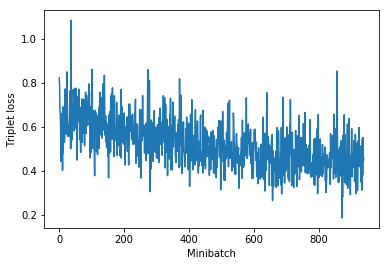

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(minibatch_triplet_train_loss)), minibatch_triplet_train_loss)
plt.ylabel('Triplet loss')
plt.xlabel('Minibatch')
plt.savefig(os.path.join(dir,'res50_result','minibatch_triplet_train_loss.png'))#,dpi = 400)
plt.show()

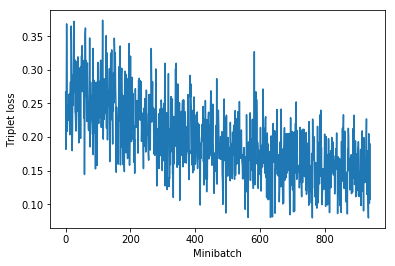

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(minibatch_triplet_test_loss)), minibatch_triplet_test_loss)
plt.ylabel('Triplet loss')
plt.xlabel('Minibatch')
plt.savefig(os.path.join(dir,'res50_result','minibatch_triplet_test_loss.png'))#,dpi = 400)
plt.show()

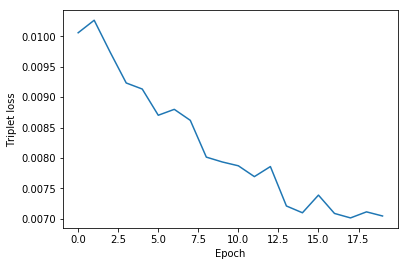

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(epoch_triplet_train_loss)), epoch_triplet_train_loss)
plt.ylabel('Triplet loss')
plt.xlabel('Epoch')
plt.savefig(os.path.join(dir,'res50_result','epoch_triplet_train_loss.png'))#,dpi = 400)
plt.show()

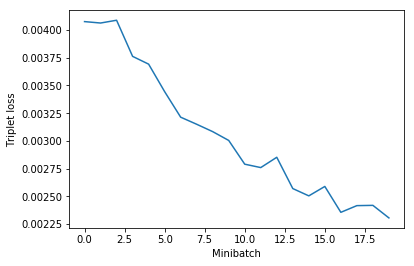

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(len(epoch_triplet_test_loss)), epoch_triplet_test_loss)
plt.ylabel('Triplet loss')
plt.xlabel('Minibatch')
plt.savefig(os.path.join(dir,'res50_result','epoch_triplet_test_loss.png'))#,dpi = 400)
plt.show()

In [0]:
dir

'drive/My Drive/Colab Notebooks/faceNet'

In [0]:
fig = os.path.join(dir,'lfw_train','Chung_Mong-joon','Chung_Mong-joon_0002.jpg')
fig

'drive/My Drive/Colab Notebooks/faceNet/lfw_train/Chung_Mong-joon/Chung_Mong-joon_0002.jpg'

In [0]:
os.path.exists(fig)

True

In [0]:
dir

<function dir>

In [0]:
from PIL import Image